In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from AutoEncoderCNN import AE_CNN
from GridSearch import GridSearch

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
torch.set_default_device(device)

In [5]:

torch.cuda.empty_cache()

In [6]:
PATH = '/groups/francescavitali/eb2/subImages_slide299/H&E' # has 506 images
BATCH_SIZE = 4 # make sure divisble by 404: 1, 2, 4, 101, 202, 404

tensor_transform = transforms.ToTensor()

dataset = datasets.ImageFolder(PATH, 
                               transform = tensor_transform) #loads the images

train_set, val_set, test_set = torch.utils.data.random_split(dataset,
                                                           [404,51,51],# 80%, 10%, 10%
                                                           generator=torch.Generator(device=device))

loader = torch.utils.data.DataLoader(dataset = train_set,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True,
                                            generator=torch.Generator(device=device))

In [7]:
len(dataset.targets)

506

In [8]:
model = AE_CNN(64,128).to(device)

model.load_state_dict(torch.load('./models/model_gs.pth')) # loading best model state
model.load_state_dict(torch.load('./models/Copy Models/model_gs_3-28-2024.pth'))

# setting the encoder and decoder for visualization
encoder = model.encoder
decoder = model.decoder

In [9]:
count = 0
with torch.no_grad():
    for(img, goal) in loader: # goal will be a tensor of len == batch_size
        if count == 1:
            break
        img = img.to(device)
        print(f'Img Shape: {img.shape}')
        encoded_img = encoder(img)
        print(f'Encoded Shape: {encoded_img.shape}')
        flattened = encoded_img.flatten(start_dim = 1)
        print(f'Flattened: {flattened.shape}')
        print(f'Goal: {goal.unsqueeze(1)}')
        print()
        count += 1

Img Shape: torch.Size([4, 3, 299, 299])
Encoded Shape: torch.Size([4, 128, 21, 21])
Flattened: torch.Size([4, 56448])
Goal: tensor([[0],
        [0],
        [0],
        [0]])



In [10]:
class NeuralNet(torch.nn.Module):
    def __init__(self, encoder):
        super().__init__()
        
        self.encoder = encoder
        self._feed_forward = torch.nn.Sequential(
            torch.nn.Linear(56448, 32768),
            torch.nn.ReLU(),
            torch.nn.Linear(32768, 16384),
            torch.nn.ReLU(),
            torch.nn.Linear(16384, 8192),
            torch.nn.ReLU(),
            torch.nn.Linear(8192, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 1),
        )
        self._sigmoid = torch.nn.Sigmoid()

        
    def encoded_without_training(self, x):
        with torch.no_grad():
            self.encoder.eval()
            encoded = self.encoder(x)
            flattened = encoded.flatten(start_dim = 1)
            return flattened
    
    def forward(self,  x):
        self.train()
        encoded = self.encoder(x) # this will update the encoder weights
        flattened = encoded.flatten(start_dim = 1)
#         flattened = self.encoded_without_training(x)
        output = self._feed_forward(flattened)
        return self._sigmoid(output)
    

In [11]:
nn = NeuralNet(encoder).to(device)

In [12]:
lr = 0.0003
weight_decay = 1e-5
EPOCHS = 15

verbose = 2

In [13]:
val_loader = torch.utils.data.DataLoader(dataset = val_set,
                                            batch_size = 1,
                                            shuffle = True,
                                            generator=torch.Generator(device=device))

In [ ]:
optimizer = torch.optim.Adam(nn.parameters(), lr = lr, weight_decay = weight_decay)
loss_function = torch.nn.BCELoss()

loss_arr = []
acc_arr = []
min_loss = None
min_acc = 0
outputs = []
early_stop = False
early_stop_depth = 20

for epoch in range(EPOCHS):
#     if epoch != 0:
#         break

    total_correct = 0
    total_samples = 0
    
    if early_stop:
        if verbose != 0:
            print(f'\n\n------EARLY STOP {min_loss}------\n\n')
        break

    count = 0

    nn.train()
    nn.to(device)
    for (image, label) in loader:
        image = image.to(device)
        label = label.to(device)
        
        output = nn(image)
    
#         print(output)
#         print(label)
        loss = loss_function(output, goal.unsqueeze(1).float())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()



        # UI
        if verbose == 2:
            sys.stdout.write('\r')
            sys.stdout.write("Epoch: {} [{:{}}] {:.1f}% | Loss: {}".format(epoch+1, "="*count, 
                                                                       len(loader)-1, 
                                                                       (100/(len(loader)-1)*count), 
                                                                       loss.item()))
            sys.stdout.flush()

        count += 1
        
#         break
#     break
    loss_arr.append(loss.item())
    
    nn.eval()
    total_correct= 0
    for (image_val, label_val) in val_loader:
        nn.eval()
        image_val = image_val.to(device)
        label_val = label_val.to(device)

        with torch.no_grad():

#             _, val_outputs = torch.max(nn(image_val), 1)
            val_outputs = torch.round(nn(image_val))
            total_samples += 1
            total_correct += (val_outputs == label_val).item()
        
    
#     if early_stop_depth >= 1 and early_stop_depth < len(acc_arr[acc_arr.index(min_acc):]):
#         early_stop = True
#         for acc_item in acc_arr[acc_arr.index(min_loss):]:
#             if acc_item < min_acc:
#                 min_acc = acc_item
#                 early_stop = False
    
        
#     if not min_loss:
#         min_loss = loss_arr[0]
#     if early_stop_depth >= 1 and early_stop_depth < len(loss_arr[loss_arr.index(min_loss):]):
#         early_stop = True
#         for loss_item in loss_arr[loss_arr.index(min_loss):]:
#             if loss_item < min_loss:
#                 min_loss = loss_item
#                 early_stop = False

    accuracy = total_correct/len(val_loader)*100
    if verbose != 0:
        print(f'\nEpoch: {epoch + 1} | Loss: {loss.item():.4f} | Val Accuracy: {accuracy:.2f}%', end='\n'*2)

Epoch: 1 [===============================================                                                     ] 47.0% | Loss: 25.0489070892334

In [ ]:
#device = torch.device('cpu')
ans = []
pre_sig = []
total_samples = 0
total_correct = 0
nn.to(device)
nn.eval()
for (image, label) in val_loader:
    nn.eval()
    image = image.to(device)
    label = label.to(device)
    
    with torch.no_grad():
        encoded = nn.encoder(image)
        not_rounded = nn._feed_forward(encoded.flatten(start_dim = 1))
        pre_sig.append(not_rounded)
        
        #outputs = torch.round(nn._sigmoid(not_rounded))
        outputs = nn._sigmoid(not_rounded)
        if outputs < 0.5: # 0.779
            outputs = 0
        else:
            outputs = 1
        #_, outputs = torch.max(nn(image), 1) # learn more about the max function i guess?
#         print(outputs)
#         print(label)
        total_samples += 1
        total_correct += (outputs == label).item()
        #ans.append((label.item(), outputs.item()))
        ans.append((label.item(), outputs))

        
print(f'Accuracy: {total_correct/len(val_loader)*100:.2f}%')


In [17]:
ans

[(0, 1),
 (1, 1),
 (0, 1),
 (1, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (1, 1),
 (0, 1),
 (1, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (1, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (1, 1),
 (0, 1),
 (0, 1),
 (1, 1),
 (1, 1),
 (0, 1),
 (1, 1),
 (0, 1),
 (0, 1),
 (1, 1),
 (1, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (0, 1),
 (1, 1),
 (1, 1),
 (0, 1),
 (0, 1),
 (1, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (1, 1),
 (1, 1),
 (0, 1)]

In [18]:
sig = []
with torch.no_grad():
    nn.eval()
#     print(val)
#     m = torch.round(val)
#     print(m.item())
    for item in pre_sig:
        val = nn._sigmoid(item)
        sig.append(val.item())

In [19]:
import matplotlib.pyplot as plt

{'whiskers': [<matplotlib.lines.Line2D at 0x7f330c749970>,
 'caps': [<matplotlib.lines.Line2D at 0x7f330c749fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f330c7496a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f330c6ed4f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f330c6ed7c0>],
 'means': []}

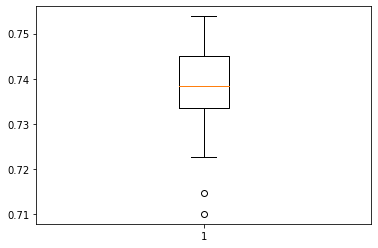

In [20]:
plt.boxplot(sig)

In [21]:
import numpy as np
print(np.quantile(sig,0.25))
print(np.quantile(sig,0.5))
print(np.quantile(sig,0.75))

0.733510822057724
0.7383217811584473
0.7450057566165924


In [22]:
sig

[0.7273550033569336,
 0.7473698854446411,
 0.7245959043502808,
 0.7289170622825623,
 0.7342904806137085,
 0.7296799421310425,
 0.7435164451599121,
 0.7328726053237915,
 0.7456302642822266,
 0.7456161975860596,
 0.7441454529762268,
 0.7355413436889648,
 0.749972403049469,
 0.735538125038147,
 0.7341027855873108,
 0.7425096035003662,
 0.7388247847557068,
 0.7424895763397217,
 0.7421096563339233,
 0.7392292618751526,
 0.7275468111038208,
 0.7435672879219055,
 0.7330038547515869,
 0.7367019057273865,
 0.7417812943458557,
 0.7475956082344055,
 0.7368027567863464,
 0.7327328324317932,
 0.7341194152832031,
 0.7538392543792725,
 0.7456120252609253,
 0.7527885437011719,
 0.7379372715950012,
 0.748124361038208,
 0.7379562258720398,
 0.7380146384239197,
 0.7359899282455444,
 0.7490084171295166,
 0.7340177893638611,
 0.7274972796440125,
 0.743715226650238,
 0.7311476469039917,
 0.7476195096969604,
 0.7146974205970764,
 0.7399376630783081,
 0.7443994879722595,
 0.7383217811584473,
 0.75201171636581